<a href="https://colab.research.google.com/github/jiayihuang1/Beat-The-Bookie/blob/main/BEATTHEBOOKIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beat the Bookies

# Introduction
To predict EPL football matches in 2022, we have built a predictive classification model that takes in features such as: ELO ratings, last N games played, distance travelled by away teams, club expenses and net spending. Data provided and additional data collected were used to generate our features. For our classification model, we considered various algorithms, that have all been trained, validated and evaluated to choose the best performing model. In our case, Linear Discriminant Analysis was the best model, producing a training accuracy of 65%.


# Import Libraries

In [ ]:
import csv
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from numpy import set_printoptions

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.utils import resample
from scipy.stats import expon
import seaborn as sb

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

# Import Data

In [ ]:
# changing directory
import os

os.chdir("\\Users\Jia Yi\Desktop\Machine Learning\Group CW")

In [ ]:
#Loading dataframe in Pandas
df_epl = pd.read_csv('epl-training2.csv')
df_dist = pd.read_csv('dist.csv')
df_pred = pd.read_csv('epl-test.csv')

# Data Pre-Processing
Firstly, we remove empty columns from all of our data.

In [ ]:
df_epl = df_epl.dropna(axis=1) # drop NaN columns
df_epl.info() # checking info of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4723 non-null   object 
 1   HomeTeam  4723 non-null   object 
 2   AwayTeam  4723 non-null   object 
 3   FTHG      4723 non-null   int64  
 4   FTAG      4723 non-null   int64  
 5   FTR       4723 non-null   object 
 6   HTHG      4723 non-null   int64  
 7   HTAG      4723 non-null   int64  
 8   HTR       4723 non-null   object 
 9   Referee   4723 non-null   object 
 10  HS        4723 non-null   int64  
 11  AS        4723 non-null   int64  
 12  HST       4723 non-null   int64  
 13  AST       4723 non-null   int64  
 14  HF        4723 non-null   int64  
 15  AF        4723 non-null   int64  
 16  HC        4723 non-null   int64  
 17  AC        4723 non-null   int64  
 18  HY        4723 non-null   int64  
 19  AY        4723 non-null   int64  
 20  HR        4723 non-null   int6

We have verified that there is nothing wrong with the data. Hence, we move on to other parts of pre-processing.

To prepare for feature engineering, we extract the list of clubnames and prepare functions to convert categorical values to integer values.

In [ ]:
# Creating row of clubnames
clubnames = []
with open('epl-training2.csv', newline = '') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
      clubnames.append(row[1])

clubnames = list(dict.fromkeys(clubnames))
clubnames.pop(0)

#Convert FTR to 0,1,2
def conv_HAD_to_012(df_in):
    df = df_in.copy() #create a new df so as to not modify the original
    # HomeWin = 0, Draw = 1, AwayWin = 2
    #"FTR" column is column number 8 (or 9)
    for n in range(df.shape[0]):
        if df.iloc[n,5] == "H":
            df.iloc[n,5]= "0"
        elif df.iloc[n,5]== "D":
            df.iloc[n,5]= "1"
        else:
            df.iloc[n,5]= "2"
    return df

# function to convert clubnames to integers
def conv_clubname_to_int(df, clubnames):
    #club names converted to a number in order of first appearance in dataset
    #Arsenal = 0, Bolton = 2, Everton = 3... Leeds = 37 (last)
    df2 = df.copy()
    for n in range(df2.shape[0]):
        for name in clubnames:
            #Change Home Team Name
            if df2.iloc[n,1] == name:
                df2.iloc[n,1] = clubnames.index(name)
            #Change Away Team Name
            if df2.iloc[n,2] == name:
                df2.iloc[n,2] = clubnames.index(name)

    return df2

Here we aim to prepare dataframes containing both the training and testing data to be used to generate features.

In [ ]:
df_pred2 = df_epl[['Date','HomeTeam','AwayTeam','FTR']].copy()
frame = [df_pred2,df_pred]
df_pred3 = pd.concat(frame,keys=["Training","Testing"])
df_pred3

Date     HomeTeam    AwayTeam  FTR
Training 0  15-08-09  Aston Villa       Wigan    A
         1  15-08-09    Blackburn    Man City    A
         2  15-08-09       Bolton  Sunderland    A
         3  15-08-09      Chelsea        Hull    H
         4  15-08-09      Everton     Arsenal    A
...              ...          ...         ...  ...
Testing  5  15-01-22    Liverpool   Brentford  NaN
         6  15-01-22    Tottenham     Arsenal  NaN
         7  15-01-22     Man City     Chelsea  NaN
         8  15-01-22    Newcastle     Watford  NaN
         9  15-01-22      Burnley   Leicester  NaN

[4733 rows x 4 columns]

# Feature Engineering
In this section, we generate all features that we believe have a strong correlation with match outcomes.
Features:
- ELO Rating - Represents relative team strength based on performance of past matches
- Last N Points - Represents most recent performance of teams
- Spending - Represents expenses and net spending at the start of each season
- Fatigue - Represents physical exhaustion of teams based on how close together their matches are
- Distance travelled by away team

## ELO Rating
Steps:
1. Prepare features for regression models  
2. Building shot and non-shot based regression models
3. Use models to predict expected match values
4. Calculate ELO rating based on expected match values
5. Update ELO rating for each team

Preparing dataset with features that are relavent and tranforming them into an appropriate format to feed into our regression model.

In [ ]:
# separating dataset for shot and non_shot based
Hshots = df_epl[['HSZA','HSZB','HSZC','HST','FTHG_P']]
Ashots = df_epl[['ASZA','ASZB','ASZC','AST','FTAG_P']]
Hnonshot = df_epl[['HP','HC','HCR','FTHG_P']]
Anonshot = df_epl[['AP','AC','ACR','FTAG_P']]

# changing home and away columns to the same name so that they can be combined
Hshots = Hshots.rename(columns={'HSZA':'SZA','HSZB':'SZB','HSZC':'SZC','HST':'SOT',
                                'FTHG_P':'FTG_P'})
Ashots = Ashots.rename(columns={'ASZA':'SZA','ASZB':'SZB','ASZC':'SZC','AST':'SOT',
                                'FTAG_P':'FTG_P'})
Hnonshot = Hnonshot.rename(columns={'HP':'P','HC':'C','HCR':'CR','FTHG_P':'FTG_P'})
Anonshot = Anonshot.rename(columns={'AP':'P','AC':'C','ACR':'CR','FTAG_P':'FTG_P'})

# combining both home and away data for regression model
frame1 = [Hshots, Ashots]
shots = pd.concat(frame1,keys=["Home","Away"])
frame2 = [Hnonshot, Anonshot]
nonshot = pd.concat(frame2,keys=["Home","Away"])

In [ ]:
# separating input and output variables for all datasets
x_shots,y_shots = shots.drop('FTG_P',axis=1),shots['FTG_P'].copy()
x_nonshot,y_nonshot = nonshot.drop('FTG_P',axis=1),nonshot['FTG_P'].copy()

### Model Training, Validation and Evaluation for regression models

#### Scoring method
We decided to use mean squared error as our evaluation metric.


In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#### Shot based expected match value model
Now we begin to build our model by performing these steps:
1. Train several models using different algorithms
2. Validate models using K-fold cross validation
3. Tune hyperparameters of relevant algorithms
4. Evaluate and select the best performing model

Here we split training data into training and validation sets for performance evaluation. We also scale our input features before feeding into our models.

In [ ]:
# splitting training and testing data
x_train, x_test, y_train, y_test = train_test_split(x_shots, y_shots, test_size = 0.2, random_state=42)

# standardise
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.transform(x_test)
x_shots_scale = scaler.transform(x_shots)

###### Multivariate Linear Regression

In [ ]:
# fit
lr_shots = LinearRegression()
lr_shots.fit(x_train_scale,y_train)

# predict
ytrain_lr_shots = lr_shots.predict(x_train_scale)
ytest_lr_shots = lr_shots.predict(x_test_scale)

# evaluate
mse_lr_shots_train = mean_squared_error(ytrain_lr_shots,y_train)
mse_lr_shots_test = mean_squared_error(ytest_lr_shots,y_test)
genloss_lr_shots = mse_lr_shots_test - mse_lr_shots_train

print("MSE of linear regressor on training data = ",mse_lr_shots_train)
print("MSE of linear regressor on testing data = ",mse_lr_shots_test)
print("difference in MSE of linear regressor = ",genloss_lr_shots)

MSE of linear regressor on training data =  1.0701079427759976
MSE of linear regressor on testing data =  1.1125681615645435
difference in MSE of linear regressor =  0.04246021878854589


In [ ]:
# perform cross validation
shots_lr_cv = cross_val_score(lr_shots, X=x_train_scale, y=y_train, cv=5, scoring=scorer)
shots_lr_err = shots_lr_cv.mean()
print('Nested Cross Validation mean test score:',shots_lr_err)

Nested Cross Validation mean test score: -1.0724026446924162


Difference between test score calculated with cross validation and score calculated with our validation set is small. Therefore, we choose to use score calculated with validation set so it can be compared to our training error.

In [ ]:
# checking parameters for shot based expected match value
param_shot = pd.Series(lr_shots.coef_, index=x_shots.columns)
np.random.seed(1)
err_shot = np.std([lr_shots.fit(*resample(x_shots,y_shots)).coef_ for i in range(1000)],0)
param_shot

SZA    0.174233
SZB    0.145753
SZC   -0.188423
SOT    0.543063
dtype: float64

These values show the coefficients for our input variables.

##### Random Forest

In [ ]:
# Create the parameter grid
RF_paramgrid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a base model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf = GridSearchCV(estimator = rf, param_grid = RF_paramgrid,
                          cv = 5, n_jobs = -1, verbose = 2, scoring=scorer)
# Fit the grid search model
grid_rf.fit(x_train_scale, y_train)

# check values of hyperparameters and best test score from cross validation
print('The best score for RF is:',grid_rf.best_score_)
print('The best parameters for RF are:',grid_rf.best_estimator_)

# build the final model with the optimum hyperparameters
rfr_model = (grid_rf.best_estimator_)

# fit the final model
RF_fit = rfr_model.fit(x_train_scale, y_train)

# predict
ytrain_rf_shots = RF_fit.predict(x_train_scale)
ytest_rf_shots = RF_fit.predict(x_test_scale)

# evaluate
mse_rf_shots_train = mean_squared_error(ytrain_rf_shots,y_train)
mse_rf_shots_test = mean_squared_error(ytest_rf_shots,y_test)
genloss_rf_shots = mse_rf_shots_test - mse_rf_shots_train

print("MSE of random forest regressor on training data = ",mse_rf_shots_train)
print("MSE of random forest regressor on testing data = ",mse_rf_shots_test)
print("difference in MSE of random forest regressor = ",genloss_rf_shots)



Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  9.2min finished


The best score for RF is: -1.0870323165571385
The best parameters for RF are: RandomForestRegressor(max_depth=100, max_features=2, min_samples_leaf=5,
                      min_samples_split=12, n_estimators=200)
MSE of random forest regressor on training data =  0.8585116343187885
MSE of random forest regressor on testing data =  1.1246989638437914
difference in MSE of random forest regressor =  0.2661873295250029


##### Support Vector Machines

In [ ]:
# defining parameter grid
SVR_paramgrid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

grid_svm = GridSearchCV(SVR(), SVR_paramgrid, refit = True, cv=5, verbose = 3, scoring=scorer)

# fit the grid search model
grid_svm.fit(x_train_scale, y_train)

# check the best hyperparameters and the best test score from cross validation
print('The best score for SVM is:',grid_svm.best_score_)
print('The best parameters for SVMM are:',grid_svm.best_estimator_)

# Building final SVM model with the best hyperparameters
svm_model = grid_svm.best_estimator_

# predict
SVM_fit = svm_model.fit(x_train_scale,y_train)
ytrain_svm_shots = SVM_fit.predict(x_train_scale)
ytest_svm_shots = SVM_fit.predict(x_test_scale)

# evaluate
mse_svm_shots_train = mean_squared_error(ytrain_svm_shots,y_train)
mse_svm_shots_test = mean_squared_error(ytest_svm_shots,y_test)
genloss_svm_shots = mse_svm_shots_test - mse_svm_shots_train

print("MSE of SVM on training data = ",mse_svm_shots_train)
print("MSE of SVM on testing data = ",mse_svm_shots_test)
print("difference in MSE of SVM = ",genloss_svm_shots)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.077, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.098, total=   1.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.076, total=   1.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.221, total=   1.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.193, total=   1.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.060, total=   0.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.057, total=   0.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.047, total=   0.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.170, total=   0.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 150.7min finished


The best score for SVM is: -1.0578897651069958
The best parameters for SVMM are: SVR(C=10, gamma=0.01)
MSE of SVM on training data =  1.0489138523405188
MSE of SVM on testing data =  1.085242944179051
difference in MSE of SVM =  0.03632909183853217


##### Model Evaluation and Selection

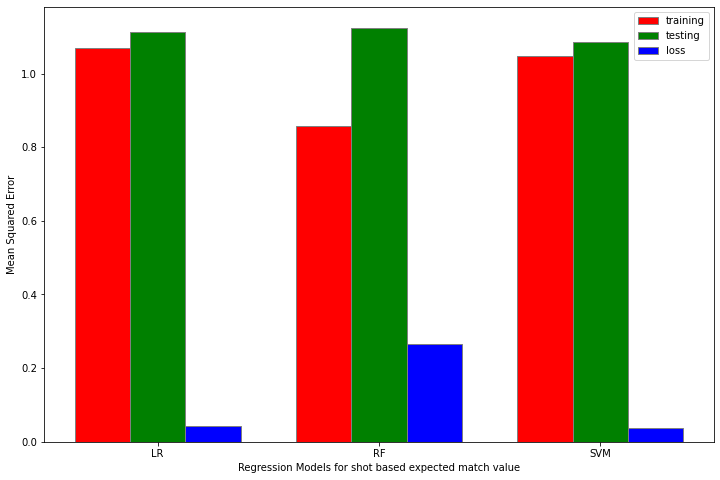

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Regression Models for shot based expected match value', ylabel='Mean Squared Error'>)

In [ ]:
# function to produce a bar plot visualising performance and the generalisation loss to aid our decision making
def barplot(training, testing, diff,shot):
    #width of bar
    barwidth =  0.25
    fig = plt.subplots(figsize = (12,8))

    # position of bar on x axis
    br1 = np.arange(len(training))
    br2 = [x + barwidth for x in br1]
    br3 = [x + barwidth for x in br2]

    # make the plot
    plt.bar(br1, training, color ='r', width = barwidth, edgecolor='grey',label='training')
    plt.bar(br2, testing, color ='g', width = barwidth, edgecolor='grey', label ='testing')
    plt.bar(br3, diff, color ='b', width = barwidth, edgecolor ='grey',label ='loss')

    # labelling
    plt.xticks([r + barwidth for r in range(len(training))],['LR','RF','SVM'])
    plt.legend()
    plt.xlabel(shot)
    plt.ylabel('Mean Squared Error')
    plt.show()

    return fig

# listing the mean squared erros as input into bar plot
shots_training_eva = [mse_lr_shots_train, mse_rf_shots_train, mse_svm_shots_train]
shots_testing_eva = [mse_lr_shots_test, mse_rf_shots_test, mse_svm_shots_test]
shots_diff_eva = [genloss_lr_shots, genloss_rf_shots, genloss_svm_shots]

# plotting
shots_plot = barplot(shots_training_eva,shots_testing_eva,shots_diff_eva,'Regression Models for shot based expected match value')
shots_plot


SVM has the seecond smallest mean squared error but it has a much lower generalisation loss compared to RF. Hence, it was chosen.

#### Non-shot based expected match value model
The same steps were repeated to build our non-shot based expected match value model.

Again, we split training data into training and validation sets for performance evaluation. We also scale our input features before feeding into our models.

In [ ]:
# splitting training and testing data
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_nonshot, y_nonshot, test_size = 0.2, random_state=42)

# standardise
scaler = StandardScaler()
x_train_scale2 = scaler.fit_transform(x_train2)
x_test_scale2 = scaler.transform(x_test2)
x_nonshot_scale = scaler.transform(x_nonshot)


##### Multivariate Linear Regression

In [ ]:
# fit
lr_nonshot = LinearRegression()
lr_nonshot.fit(x_train_scale2,y_train2)

# predict
ytrain_lr_nonshot = lr_nonshot.predict(x_train_scale2)
ytest_lr_nonshot = lr_nonshot.predict(x_test_scale2)

# evaluate
mse_lr_nonshot_train = mean_squared_error(ytrain_lr_nonshot,y_train2)
mse_lr_nonshot_test = mean_squared_error(ytest_lr_nonshot,y_test2)
genloss_lr_nonshot = mse_lr_nonshot_test - mse_lr_nonshot_train

print("MSE of linear regressor on training data = ",mse_lr_nonshot_train)
print("MSE of linear regressor on testing data = ",mse_lr_nonshot_test)
print("difference in MSE of linear regressor = ",genloss_lr_nonshot)


MSE of linear regressor on training data =  1.3835395867250249
MSE of linear regressor on testing data =  1.4287510232811902
difference in MSE of linear regressor =  0.04521143655616533


In [ ]:
# cross validation
nonshot_lr_cv = cross_val_score(lr_nonshot, X=x_train_scale2, y=y_train2, cv=5, scoring=scorer)
nonshot_lr_err = nonshot_lr_cv.mean()
print('Nested Cross Validation mean test score:',nonshot_lr_err)

Nested Cross Validation mean test score: -1.3874651723009088


For the same reasons as above, we choose to use mean squared error from our validation set.

In [ ]:
# checking parameters for non_shot based expected match value
param_nonshot = pd.Series(lr_nonshot.coef_, index=x_nonshot.columns)
np.random.seed(1)
err_nonshot = np.std([lr_nonshot.fit(*resample(x_nonshot,y_nonshot)).coef_ for i in range(1000)],0)
param_nonshot

P     0.245753
C     0.244139
CR   -0.349918
dtype: float64

These values show the coefficients for our input variables.

##### Random Forest

In [ ]:
# Create a base model
rf2 = RandomForestRegressor()

# Instantiate the grid search model
grid_rf2 = GridSearchCV(estimator = rf2, param_grid = RF_paramgrid,
                          cv = 5, n_jobs = -1, verbose = 2, scoring=scorer)
# Fit the grid search model
grid_rf2.fit(x_train_scale2, y_train2)

# checking values of hyperparameters and best test score
print (grid_rf2.best_score_)
print (grid_rf2.best_estimator_)

# build the final model with the optimum hyperparameters
rf2_model = grid_rf2.best_estimator_

# fit the final model
RF2_fit = rf2_model.fit(x_train_scale2, y_train2)

# predict
ytrain_rf_nonshot = RF2_fit.predict(x_train_scale2)
ytest_rf_nonshot = RF2_fit.predict(x_test_scale2)

# evaluate
mse_rf_nonshot_train = mean_squared_error(ytrain_rf_nonshot,y_train2)
mse_rf_nonshot_test = mean_squared_error(ytest_rf_nonshot,y_test2)
genloss_rf_nonshot = mse_rf_nonshot_test - mse_rf_nonshot_train

print("MSE of random forest regressor on training data = ",mse_rf_nonshot_train)
print("MSE of random forest regressor on testing data = ",mse_rf_nonshot_test)
print("difference in MSE of random forest regressor = ",genloss_rf_nonshot)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 12.4min finished


-1.4214740533336951
RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=5,
                      min_samples_split=12, n_estimators=200)
MSE of random forest regressor on training data =  0.9724646232981622
MSE of random forest regressor on testing data =  1.4492603636460581
difference in MSE of random forest regressor =  0.47679574034789596


##### Support Vector Machines

In [ ]:
grid_svm2 = GridSearchCV(SVR(), SVR_paramgrid, refit = True, cv=5, verbose = 3, scoring=scorer)

# fitting the model for grid search
grid_svm2.fit(x_train2, y_train2)

# check best hyperparameter and test scores
print('The best score for SVM is:',grid_svm2.best_score_)
print('The best parameters for SVMM are:',grid_svm2.best_estimator_)

# Building final SVM model with the best hyperparameters
svm2_model = grid_svm2.best_estimator_

# fit the final model
SVM2_fit = svm2_model.fit(x_train_scale2,y_train2)

#predict
ytrain_svm_nonshot = SVM2_fit.predict(x_train_scale2)
ytest_svm_nonshot = SVM2_fit.predict(x_test_scale2)

# evaluate
mse_svm_nonshot_train = mean_squared_error(ytrain_svm_nonshot,y_train2)
mse_svm_nonshot_test = mean_squared_error(ytest_svm_nonshot,y_test2)
genloss_svm_nonshot = mse_svm_nonshot_test - mse_svm_nonshot_train

print("MSE of SVM on training data = ",mse_svm_nonshot_train)
print("MSE of SVM on testing data = ",mse_svm_nonshot_test)
print("difference in MSE of SVM = ",genloss_svm_nonshot)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.415, total=   1.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.466, total=   1.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.463, total=   1.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.644, total=   1.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-1.565, total=   1.6s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.364, total=   2.9s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.412, total=   2.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.421, total=   2.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-1.600, total=   3.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 212.0min finished


The best score for SVM is: -1.3981393444149872
The best parameters for SVMM are: SVR(C=1, gamma=0.001)
MSE of SVM on training data =  1.4725724119100394
MSE of SVM on testing data =  1.4802988070256082
difference in MSE of SVM =  0.007726395115568829


##### Model Evaluation and Selection

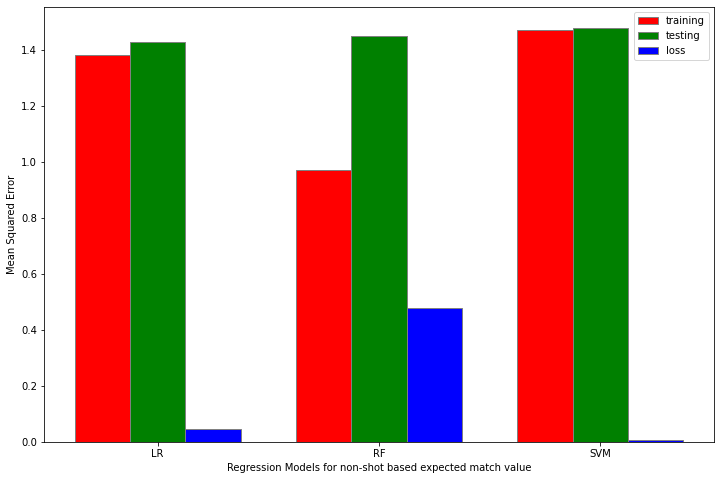

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Regression Models for non-shot based expected match value', ylabel='Mean Squared Error'>)

In [ ]:
# adding all errors into a list to display in bar plot
nonshot_training_eva =[mse_lr_nonshot_train, mse_rf_nonshot_train, mse_svm_nonshot_train]
nonshot_testing_eva =[mse_lr_nonshot_test, mse_rf_nonshot_test, mse_svm_nonshot_test]
nonshot_diff_eva = [genloss_lr_nonshot, genloss_rf_nonshot, genloss_svm_nonshot]

# plotting
nonshot_plot = barplot(nonshot_training_eva,nonshot_testing_eva,nonshot_diff_eva,'Regression Models for non-shot based expected match value')
nonshot_plot

LR has the seecond smallest mean squared error but it has a much lower generalisation loss compared to RF. Hence, it was chosen.

#### Predicting with selected models

In [ ]:
shots_match = SVM_fit.predict(x_shots_scale) # best model for shots is SVM
nonshot_match = lr_nonshot.predict(x_nonshot_scale) # best model for non-shots is LR

# inserting features into dataset
shots['exp_match'] = shots_match
nonshot['exp_match'] = nonshot_match

Now that we have the expected match value for both shots and non-shot, we generate the overall expected match value by using their weighted average.

In [ ]:
# calculating weighted average
w1 = 0.8 # weightage of shot based expected match value
w2 = 1-w1 # weightage of non-shot based expected match value
avg_expmatch = w1*(shots_match) + w2*(nonshot_match)

# separating into home and away teams
home_expmatch = avg_expmatch[:4723]
away_expmatch = avg_expmatch[4723:]

Then, we adjust the overall expected match value by adding the probability of penalty scoring multiplied by the total number of penalty attempts, obtaining our final expected match value.

In [ ]:
# adjusting expected match value based on penalty attempts
# probability of a penalty scoring is 0.76
Hpen_att = df_epl['HPA']
Apen_att = df_epl['APA']
home_expmatch2 = home_expmatch + 0.76*(Hpen_att)
away_expmatch2 = away_expmatch + 0.76*(Apen_att)

# inserting expected values into dataset
df_epl['H_EXP_adj'] = home_expmatch2.tolist()
df_epl['A_EXP_adj'] = away_expmatch2.tolist()
df_epl['H_EXP'] = home_expmatch.tolist()
df_epl['A_EXP'] = away_expmatch.tolist()

### Calculation of ELO
Now that we have all of the expected match values of both teams for each match, we take the difference between the values to decide how much we change the ELO rating after each match.

#### Defining functions
Here, we are preparing functions that will be used to update the ELO rating in certain circumstances:
1. Initial ELO rating of all teams is set to 1500
2. Update ELO rating after each match
3. Update ELO rating between each season
4. Update average ELO rating once home/away rating has been changed

In [ ]:
# function to give initial elo
def initialize_elo(clubnames): ### clubnames to be in data preprocessing
    EloHome_list = []
    EloAway_list = []
    EloAvg_list = []
    for club in clubnames:
        EloHome_list.append(1500)
        EloAway_list.append(1500)
        EloAvg_list.append(1500)

    return EloHome_list, EloAway_list, EloAvg_list

# function to calculate and update elo after each match with difference between both team's expected match value
def update_elo_match(df, n, elohomelist, eloawaylist, eloavglist):

    w3 = 20 # sensitivity of ELO changes

    # storing teams ELO values before each match in seperate variables
    elohome1 = elohomelist[df.iloc[n,1]]
    eloaway1 = eloawaylist[df.iloc[n,1]]
    elohome2 = elohomelist[df.iloc[n,2]]
    eloaway2 = eloawaylist[df.iloc[n,2]]

    # storing expected match values based on performance during the match in seperate variables
    xg1 = df.iloc[n,38]
    xg2 = df.iloc[n,39]

    if xg1 > xg2: #if home team's expected match value is higher
        diff = xg1 - xg2 # take difference between expected match value

        if elohome1 > eloaway2: # if home team was expected to win
            w4 = (elohome1 - eloaway2)/(elohome1 + eloaway2) # weight to adjust change in ELO based on which team was expected to win
            new_elohome1 = elohome1 + (w3 * diff) - w4 # home team ELO is increased by a lesser amount because they were expected to win
            new_eloaway2 = eloaway2 - (w3 * diff) + w4 # away team ELO is reduced by a lesser amount beacause they were expected to lose
        elif elohome1 < eloaway2: # if home team was expected to lose
            w4 = (eloaway2 - elohome1)/(elohome1 + eloaway2)
            new_elohome1 = elohome1 + (w3 * diff) + w4
            new_eloaway2 = eloaway2 - (w3 * diff) - w4
        else:
            new_elohome1 = elohome1 + (w3 * diff)
            new_eloaway2 = eloaway2 - (w3 * diff)

    elif xg1 < xg2: # if home team's expected match value is lower
        diff2 = xg2 - xg1 # difference

        if eloaway2 > elohome1: # if away team was expected to win
            w4 = (eloaway2 - elohome1)/(eloaway2 + elohome1)
            new_elohome1 = elohome1 - (w3 * diff2) + w4 # decrease home team's home elo by a lesser amount
            new_eloaway2 = eloaway2 + (w3 * diff2) - w4 # increase away team's away elo by a lesser amount
        elif eloaway2 < elohome1: # if away team was expected to lose
            w4 = (elohome1 - eloaway2)/(eloaway2 + elohome1)
            new_elohome1 = elohome1 - (w3 * diff2) - w4
            new_eloaway2 = eloaway2 + (w3 * diff2) + w4
        else:
            new_elohome1 = elohome1 - (w3 * diff2)
            new_eloaway2 = eloaway2 + (w3 * diff2)

    new_eloavg1 = (new_elohome1 + eloaway1) / 2 # update average elo of home team
    new_eloavg2 = (new_eloaway2 + elohome2) / 2 # update average elo of away team

    # update new elo ratings into elo_list
    elohomelist[df.iloc[n,1]] = new_elohome1 # home team's elo home is updated
    eloavglist[df.iloc[n,1]] = new_eloavg1 # home team's avg elo is updated
    eloawaylist[df.iloc[n,2]] = new_eloaway2 # away team's elo away is updated
    eloavglist[df.iloc[n,2]] = new_eloavg2 # away team's avg elo is updated

    return elohomelist, eloawaylist, eloavglist

# function to update elo after each season
def update_elo_season(elohomelist, eloawaylist):
    w5 = 2/3 # weight of previous season ELO rating carried over
    for n in range(len(elohomelist)):
        elohomelist[n] = (w5*elohomelist[n])+((1-w5)*1500)
        eloawaylist[n] = (w5*eloawaylist[n])+((1-w5)*1500)

    return elohomelist, eloawaylist

# function to update avg elo after home or away elo has been changed
def update_avg_elo(elohomelist, eloawaylist, eloavglist):
    for n in range(len(EloHome_list)):
        eloavglist[n] = (elohomelist[n] + eloawaylist[n]) / 2

    return eloavglist

# function to check days since last match to judge if it is a new season
def cal_days (df,n): # n is the row number
    if n == 0:
        daysdiff = 0 # first match no days difference
    else:
        date1 = datetime.strptime(df['Date'][n],'%d-%m-%y') # date for current match
        date2 = datetime.strptime(df['Date'][n-1],'%d-%m-%y') # date for previous match
        daysdiff = (date1.date() - date2.date()).days # days difference between previous and current match
    return daysdiff

#### Updating ELO
1. ELO will be updated each match based on difference between expected match values and initial ELO ratings
2. ELO will be regulated between each season to ensure it stays within reasonable range
3. ELO will be inserted into final dataset to be used for classification model

Preparing dataset to store initial and final ELO ratings for each team.

In [ ]:
# converting clubnames to integers
df_epl2 = conv_clubname_to_int(df_epl,clubnames)

# initialize elo for all home away and avg elo for all teams
EloHome_list, EloAway_list, EloAvg_list = initialize_elo(clubnames)
EloAvg_list = update_avg_elo(EloHome_list, EloAway_list, EloAvg_list)

# new columns to store ELO ratings for each match
df_epl["Home Team Elo After"] = ""
df_epl["Away Team Elo After"] = ""
df_epl["Home Team Initial Elo"] = ""
df_epl["Away Team Initial Elo"] = ""

Before each match, we check if it is a new season and update ELO rating accordingly.

In [ ]:
for n in range(df_epl.shape[0]):
    # check if it is a new season
    daysdiff = cal_days(df_epl,n)
    if daysdiff > 30: # matches within a season will usually take place within 30 days
        EloHome_list, EloAway_list = update_elo_season(EloHome_list,EloAway_list) # call function to update ELO between seasons
        EloAvg_list = update_avg_elo(EloHome_list, EloAway_list, EloAvg_list)
    else:
        pass

    # update initial elo ratings into table row by row which is the weighted average of average and home/away ELO
    w6 = 0.8 # weightage for home/away elo
    w7 = 1-w6 # weightage for avg elo
    initial_elohome = (w6 * EloHome_list[df_epl2.iloc[n,1]]) + (w7 * EloAvg_list[df_epl2.iloc[n,1]])
    initial_eloaway = (w6 * EloAway_list[df_epl2.iloc[n,2]]) + (w7 * EloAvg_list[df_epl2.iloc[n,2]])
    df_epl.iloc[n,44] = initial_elohome
    df_epl.iloc[n,45] = initial_eloaway

    # update elo after each match
    EloHome_list, EloAway_list, EloAvg_list = update_elo_match(df_epl2, n, EloHome_list, EloAway_list, EloAvg_list)

    # update new elo ratings into table row by row
    new_elohome = (w6 * EloHome_list[df_epl2.iloc[n,1]]) + (w7 * EloAvg_list[df_epl2.iloc[n,1]])
    new_eloaway = (w6 * EloAway_list[df_epl2.iloc[n,2]]) + (w7 * EloAvg_list[df_epl2.iloc[n,2]])
    df_epl.iloc[n,42] = new_elohome
    df_epl.iloc[n,43] = new_eloaway

## Last N Points

In [ ]:
# Last N Points
clubnames = []
for name in df_epl["HomeTeam"]:
    if name not in clubnames:
        clubnames.append(name)

def create_team_history(df, clubnames):
    #initialize the dictionary
    team_history_dict = {}
    for club in clubnames:
        #n = clubnames.index(club)
        team_history_dict[club] = ["0"]

    for index in range(df.shape[0]):
        if df.iloc[index,2] == "H": #home win
            team_history_dict[df.iloc[index,0]].append("3") #3 points to home team
            team_history_dict[df.iloc[index,1]].append("0") #0 points to away team

        elif df.iloc[index,2] == "A": #home win
            team_history_dict[df.iloc[index,0]].append("0") #0 points to home team
            team_history_dict[df.iloc[index,1]].append("3") #3 points to away team

        if df.iloc[index,2] == "D": #home win
            team_history_dict[df.iloc[index,0]].append("1") #3 points to home team
            team_history_dict[df.iloc[index,1]].append("1") #0 points to away team

    return team_history_dict # Dictionary of all team's win/loss

def last_n_points(n, match_num, team_history, clubname):
    last_n_points = 0

    if match_num >= n:
        for k in range(match_num-n,match_num):
            last_n_points = last_n_points +  int(team_history[clubname][k])

    elif match_num == 0:
        last_n_points = 0

    else:
        for k in range(0,match_num):
            last_n_points = last_n_points +  int(team_history[clubname][match_num])

    return last_n_points

def populate_last_n_points(n, df,df2, team_history):
    club_cumulative_matches = {}

    for club in clubnames:
        club_cumulative_matches[club] = -1 #trust me bcos i want it to start from zero (see below)

    for index in range(df.shape[0]):
        home_team = df.iloc[index,0]
        away_team = df.iloc[index,1]

        club_cumulative_matches[home_team] = club_cumulative_matches[home_team] + 1
        club_cumulative_matches[away_team] = club_cumulative_matches[away_team] + 1

        home_team_match_num = club_cumulative_matches[home_team]
        away_team_match_num = club_cumulative_matches[away_team]


        home_last_n_points = last_n_points(n,home_team_match_num, team_history,home_team)
        away_last_n_points = last_n_points(n,away_team_match_num, team_history,away_team)
        #df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'), index=['x', 'y'])
        #df = df.append({'A': i}, ignore_index=True)
        df3 = pd.DataFrame([[home_last_n_points,away_last_n_points]])
        df2 = df2.append(df3,ignore_index=True)


    return df2
# Hshots = Hshots.rename(columns={'HSZA':'SZA','HSZB':'SZB','HSZC':'SZC','HST':'SOT',
                              #  'FTHG_P':'FTG_P'})

df_lastNPoints = pd.DataFrame()
#s2 = pd.Series([0,0], index=['HomeTeamLastNPoints','AwayTeamLastNPoints'])
#df_lastNPoints = df_lastNPoints.append(s2,ignore_index=True)
df_working = df_pred3.drop(['Date'],axis = 1)
team_history = create_team_history(df_working, clubnames)
df_lastNPoints = populate_last_n_points(5, df_working, df_lastNPoints, team_history)
df_lastNPoints.columns.map(type)
df_lastNPoints.columns = df_lastNPoints.columns.astype(str)
df_lastNPoints = df_lastNPoints.rename(columns={'0':'HomeTeamLastNPoints','1':'AwayTeamLastNPoints'})
#df = lastNPoints_df.drop(['AwayTeam','HomeTeam','FTR'],axis = 1)
lastNPoints_df_train = df_lastNPoints.iloc[:4723].copy()
lastNPoints_df_test = df_lastNPoints.iloc[4723:].copy()
lastNPoints_df_train
#df_lastNPoints

,HomeTeamLastNPoints,AwayTeamLastNPoints
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
4718,8,9
4719,15,6
4720,4,5
4721,4,5


## Spending

In [ ]:
#Spending
#Scrapping for spend data
#Transfermarkt webscraping function from https://fcpython.com/blog/introduction-scraping-data-transfermarkt

#Webscraping will not work if website knows we are not a browser, so a fake browser is used
headers = {'User-Agent':
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
#Define function to take the year, and output table of expenses and balance for each season
def get_spend(year):
    pageTree = requests.get('https://www.transfermarkt.co.uk/premier-league/einnahmenausgaben/wettbewerb/GB1/plus/0?ids=a&sa=&saison_id='+year+'&saison_id_bis='+year+'&nat=&pos=&altersklasse=&w_s=&leihe=false&intern=1', headers=headers)
    pageSoup = BeautifulSoup(pageTree.content, 'html.parser')
    club = pageSoup.find_all("td", {"class": "hauptlink no-border-links"})
    ex = pageSoup.find_all("td", {"class": "rechts hauptlink redtext"})
    bal = pageSoup.find_all("td", {"class": "rechts hauptlink"})
    rows=[]
    #The team names are different on the website, use dictionary to replace each name
    team_name_match_dict={'Arsenal FC':'Arsenal',
                      'Chelsea FC':'Chelsea',
                      'Blackburn Rovers':'Blackburn',
                      'Bolton Wanderers':'Bolton',
                      'Liverpool FC':'Liverpool',
                      'Sunderland AFC':'Sunderland',
                      'Fulham FC':'Fulham',
                      'Portsmouth FC':'Portsmouth',
                      'Everton FC':'Everton',
                      'Middlesbrough FC':'Middlesbrough',
                      'Burnley FC':'Burnley',
                      'Brighton & Hove Albion':'Brighton',
                      'Cardiff City':'Cardiff',
                      'Huddersfield Town':'Huddersfield',
                      'Hull City':'Hull',
                      'Leicester City':'Leicester',
                      'Watford FC':'Watford',
                      'Manchester City':'Man City',
                      'Manchester United':'Man United',
                      'AFC Bournemouth':'Bournemouth',
                      'Southampton FC':'Southampton',
                      'Newcastle United':'Newcastle',
                      'Norwich City':'Norwich',
                      'Queens Park Rangers':'QPR',
                      'Stoke City':'Stoke',
                      'Swansea City':'Swansea',
                      'Tottenham Hotspur':'Tottenham',
                      'West Bromwich Albion':'West Brom',
                      'West Ham United':'West Ham',
                      'Wigan Athletic':'Wigan',
                      'Wolverhampton Wanderers':'Wolves'}
    #Remove symbols and units, and replace them
    for i in range(len(club)):
        ex[i]=ex[i].text.replace('£','').replace('m','000000').replace('Th.','000').replace('.','')
        bal[i]=bal[i].text.replace('£','').replace('m','000000').replace('Th.','000').replace('.','')
        #One particular club did not spend any money during a season. This changes that from 'null' to zero
        if ex[i]=='-':
          ex[i]=0
        rows.append([club[i].text,ex[i],bal[i]])
    spend_df = pd.DataFrame(rows,columns=['Club','Expenses','Balance'])
    spend_df['Club']=spend_df['Club'].replace(team_name_match_dict)
    spend_df[['Expenses','Balance']]=MaxAbsScaler().fit(spend_df[['Expenses','Balance']]).transform(spend_df[['Expenses','Balance']])
    return spend_df

#Create dictionary for spending
spend_d={}
for i in range(2008,2022):
    spend_d["{0}".format(i)]=get_spend(str(i))

def get_spending():
  data = df_pred3
  rows=[]
  for i in range(len(data)):
      row=[0,0,0,0]
      #Change date in each row from string to datetime object
      try:
          t=datetime.strptime(data['Date'][i],'%d-%m-%y')
      except ValueError:
          t=datetime.strptime(data['Date'][i],'%d-%m-%y')
      #To determine which season the current match belongs to, it is observed that the EPL season starts around August and ends around June
      #Therefore, if the month is greater than or equal to 8, it is assigned the current year
      #If the month is less than or equal to 6, it is assigned the previous year
      if t.month>=8:
          for j in range(len(spend_d[str(t.year)])):
              if spend_d[str(t.year)]['Club'][j]==data['HomeTeam'][i]:
                  row[0]=spend_d[str(t.year)]['Expenses'][j]
                  row[1]=spend_d[str(t.year)]['Balance'][j]
              elif spend_d[str(t.year)]['Club'][j]==data['AwayTeam'][i]:
                  row[2]=spend_d[str(t.year)]['Expenses'][j]
                  row[3]=spend_d[str(t.year)]['Balance'][j]
      elif t.month<=6:
          for k in range(len(spend_d[str(t.year-1)])):
              if spend_d[str(t.year-1)]['Club'][k]==data['HomeTeam'][i]:
                  row[0]=spend_d[str(t.year-1)]['Expenses'][k]
                  row[1]=spend_d[str(t.year-1)]['Balance'][k]
              elif spend_d[str(t.year-1)]['Club'][k]==data['AwayTeam'][i]:
                  row[2]=spend_d[str(t.year-1)]['Expenses'][k]
                  row[3]=spend_d[str(t.year-1)]['Balance'][k]
      rows.append(row)
  spending_df=pd.DataFrame(rows,columns=['HomeEx','HomeNetSpend','AwayEx','AwayNetSpend'])
  return spending_df
spending_df=get_spending()
spending_df_train = spending_df.iloc[:4723]
spending_df_test = spending_df.iloc[4723:]
spending_df_train

,HomeEx,HomeNetSpend,AwayEx,AwayNetSpend
0,0.318398,-0.211064,0.120540,0.068558
1,0.090141,0.198865,1.000000,-1.000000
2,0.081466,-0.085106,0.302783,-0.198487
3,0.203666,-0.229787,0.096100,0.015792
4,0.158181,0.042931,0.081466,0.303830
...,...,...,...,...
4718,0.363258,-0.159732,0.602791,0.199543
4719,0.769928,-0.651248,0.000000,0.000000
4720,0.336353,0.049927,0.158816,0.038179
4721,0.443438,-0.539158,0.260266,0.126774


## Fatigue

In [ ]:
#Fatigue
def get_fatigue():
  data = pd.read_csv('epl-training2.csv')
  fatigue_df = pd.DataFrame(30,index=range(len(data)),columns=['HFati','AFati']) #Create initial dataframe with 30 days as values
  clubnames = data['HomeTeam'].unique().tolist() #Get club names
  for name in clubnames:
      a=np.sort(np.append(data[data['HomeTeam']==name].index.values,data[data['AwayTeam']==name].index.values))
      rows = []
      s = []
      #Find all rows with specific club, and convert string to datetime object
      for i in a:
          t = []
          t.append(i)
          try:
              t.append(datetime.strptime(data['Date'][i],'%d-%m-%y'))
          except ValueError:
              t.append(datetime.strptime(data['Date'][i],'%d-%m-%y'))
          s.append(t)
      #Find difference in days between matches
      for i in range(len(s)-1):
          row = [s[i+1][0],(s[i+1][1].date()-s[i][1].date()).days]
          rows.append(row)
      f_df = pd.DataFrame(rows,columns=['n','F'])
      #Change values in fatigue_df from 30 days to actual number of days between matches
      for i in range(len(f_df['n'])):
          if data['HomeTeam'][f_df['n'][i]]==name:
              fatigue_df['HFati'][f_df['n'][i]]=f_df['F'][i]
          elif data['AwayTeam'][f_df['n'][i]]==name:
              fatigue_df['AFati'][f_df['n'][i]]=f_df['F'][i]
  #Transform number of days to a fatigue index between 0 and 1
  fatigue_df['HFati']=1/(1+np.exp(0.5*(fatigue_df['HFati']-3)))
  fatigue_df['AFati']=1/(1+np.exp(0.5*(fatigue_df['AFati']-3)))
  return fatigue_df
fatigue_df=get_fatigue()
fatigue_df

C:\Users\Jia Yi\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,HFati,AFati
0,0.000001,0.000001
1,0.000001,0.000001
2,0.000001,0.000001
3,0.000001,0.000001
4,0.000001,0.000001
...,...,...
4718,0.500000,0.500000
4719,0.500000,0.500000
4720,0.017986,0.377541
4721,0.500000,0.377541


## Distance Travelled by Away Team

In [ ]:
#Distance Travelled
#Distance data taken from Google Maps, shortest distance by car from away team stadium to home team stadium
def get_dist():
  data = df_pred3
  dist = pd.read_csv('dist.csv') #Import distance from each club
  rows = []
  for i in range(len(data)):
      h = data['HomeTeam'][i]
      a = data['AwayTeam'][i]
      for j in dist[dist['Home']==h].index.values:
          if dist['Away'][j] == a:
              rows.append(dist['Miles'][j])
      for j in dist[dist['Away']==h].index.values:
          if dist['Home'][j] == a:
              rows.append(dist['Miles'][j])
  dist_df = pd.DataFrame(rows,columns=['Away travel distance'])
  return dist_df
dist_df=get_dist()
dist_df_train = dist_df.iloc[:4723]
dist_df_test = dist_df.iloc[4723:]
dist_df_test

,Away travel distance
4723,85.4
4724,200.0
4725,244.0
4726,46.1
4727,156.0
4728,215.0
4729,4.5
4730,205.0
4731,267.0
4732,145.0


Now, we combine all of our features into a new dataset to be used for our classification model.

In [ ]:
# copying features from their respective datasets to a new dataframe
# to reduce the number of features we take the difference between home and away values for all features except away distance travelled as that only applies to the away team
df_ftr = df_epl.join(pd.get_dummies(df_epl['FTR'],prefix='FTR'))
df_final = df_ftr[["FTR"]].copy()
df_final['ExDiff'] = spending_df_train['HomeEx']-spending_df_train['AwayEx']
df_final['NetSpendDiff'] = spending_df_train['HomeNetSpend']-spending_df_train['AwayNetSpend']
df_final['Away travel distance'] = dist_df_train[['Away travel distance']].copy()
df_final['FatiDiff'] = fatigue_df['HFati']-fatigue_df['AFati']
df_final['LastNPointsDiff'] = lastNPoints_df_train["HomeTeamLastNPoints"] - lastNPoints_df_train["AwayTeamLastNPoints"]
df_final['ELODiff'] = df_epl["Home Team Initial Elo"] - df_epl["Away Team Initial Elo"]
df_final['FoulsDiff'] = df_epl['HF']-df_epl['AF']
df_final['YcardDiff']= df_epl['HY']-df_epl['AY']
df_final['RcardDiff']=df_epl['HR']-df_epl['AR']
df_final

,FTR,ExDiff,NetSpendDiff,Away travel distance,FatiDiff,LastNPointsDiff,ELODiff,FoulsDiff,YcardDiff,RcardDiff
0,A,0.197858,-0.279622,89.4,0.000000,0,0,1,0,0
1,A,-0.909859,1.198865,27.2,0.000000,0,0,3,1,0
2,A,-0.221317,0.113381,147.0,0.000000,0,0,6,1,0
3,H,0.107566,-0.245579,198.0,0.000000,0,0,-2,-1,0
4,A,0.076714,-0.260898,208.0,0.000000,0,0,-2,0,0
...,...,...,...,...,...,...,...,...,...,...
4718,A,-0.239533,-0.359276,161.0,0.000000,-1,2.4082,3,2,0
4719,H,0.769928,-0.651248,40.3,0.000000,9,874.921,-4,0,0
4720,A,0.177536,0.011747,190.0,-0.359554,-1,190.748,-3,2,0
4721,D,0.183172,-0.665932,83.5,0.122459,-1,131.178,-4,-2,0


# Feature Selection
Now that we have all our features, we can evaluate the strength of correlation between all features and our target value. We will be using a statistical method to choose our features for our final predictive classification model.

In [ ]:
# Separating dataset into x and y
X,Y = df_final.drop(['FTR'],axis=1), df_final["FTR"].copy()

# standardising data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

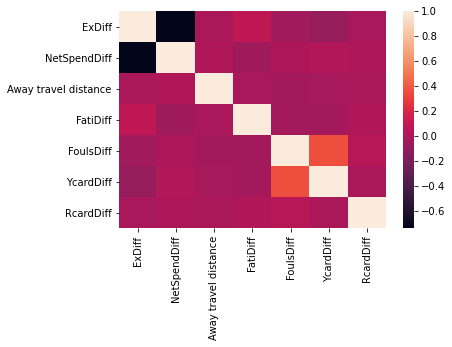

In [ ]:
corr3 = df_final.corr()
sb.heatmap(corr3)
plt.show()

Heatmap was generated to evaluate the correlation between the features. No strong correlations was observed. Hence, no changes were made to the features.

In [ ]:
# labellling discrete features
discrete = [0,0,1,0,0,0,0,0,0,0]

# calculating scores which represent the correlation between each feature and target value
MIscores = mutual_info_classif(X,Y,random_state=1,discrete_features=discrete)
thresholdMIscore = np.percentile(MIscores,50) # choose the 5 highest correlated features

# display scores more clearly
sortedMIscores = sorted(zip(MIscores,list(X)),reverse=True)

# show list of scores, removing those that do not meet the threshold
print('MI scores for all variables of X:')
for score, fname in sortedMIscores:
    print(fname,score)
    if score < thresholdMIscore:
        X = X.drop(fname,axis=1)

print('thresholdMIscore:',thresholdMIscore)
_,n_features = X.shape
print('Number of remaining features:',n_features)

MI scores for all variables of X:
ExDiff 1.0253407230892182
NetSpendDiff 1.0206176221571792
ELODiff 0.0879443046056596
LastNPointsDiff 0.017948494412272087
Away travel distance 0.011818429063986002
RcardDiff 0.007425110834361925
YcardDiff 0.005092392142549196
FoulsDiff 0.0
FatiDiff 0.0
thresholdMIscore: 0.011818429063986002
Number of remaining features: 5


After the feature selection process, the remaining features are: difference in expenses, difference in net spending, difference in ELO rating, difference in last N points and away distance travelled.

# Classification Models
Now, we use all our selected features to build our classification model. The process is the same as how we built our regression model which is:
1. Train several models using different algorithms
2. Validate models using K-fold cross validation
3. Tune hyperparameters of relevant algorithms
4. Evaluate and select the best performing model

However, different evaluation metrics are used for classification. They are:
- Accuracy
- F1 score
- Precision
- Recall

In [ ]:
# splitting data to training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

# standardise
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## Naive Bayes

In [ ]:
# create a base model
nb = GaussianNB()

# fit
nb.fit(X_train_scale, Y_train)

# predict
y_nb_train = nb.predict(X_train) #prediction
y_nb_test = nb.predict(X_test)

# evaluate
acc_nb_test = accuracy_score(Y_test,y_nb_test)
acc_nb_train = accuracy_score(Y_train,y_nb_train)
acc_nb_diff = acc_nb_train - acc_nb_test

print('accuracy of naive bayes for testing set is:',acc_nb_test)
print('accuracy of naive bayes for training set is:',acc_nb_train)
print('difference in accuracy for naive bayes is:',acc_nb_diff)
print(metrics.classification_report(y_nb_test,Y_test))

accuracy of naive bayes for testing set is: 0.4486772486772487
accuracy of naive bayes for training set is: 0.45897300158814186
difference in accuracy for naive bayes is: 0.010295752910893186
              precision    recall  f1-score   support

           A       0.02      0.55      0.04        11
           D       0.00      0.00      0.00         0
           H       1.00      0.45      0.62       934

    accuracy                           0.45       945
   macro avg       0.34      0.33      0.22       945
weighted avg       0.99      0.45      0.61       945



C:\Users\Jia Yi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# cross validation
nb_cv = cross_val_score(nb, X=X_train_scale, y=Y_train, cv=5, scoring='accuracy')
nb_err = nb_cv.mean()
print('Nested Cross Validation mean test score:',nb_err)

Nested Cross Validation mean test score: 0.5119086162794773


Since the cross validation mean test score is much larger than our validation test score, we choose to use the cross validation mean test score.

## Logistic Regression

In [ ]:
# set parameter grid
paramgrid_lor = [
    {'penalty' : ['l2'],
    'solver' : ['lbfgs'],
    'class_weight' : ['balanced',None]},
    {'penalty' : ['l1'],
    'C' : [expon(scale=100)],
    'solver' : ['saga'],
    'class_weight' : ['balanced',None]}
]

# instantiate grid search
grid_lor = GridSearchCV(LogisticRegression(),paramgrid_lor,cv=5,verbose=3,scoring='accuracy')

# fit grid search model
grid_lor.fit(X_train_scale, Y_train)

# check the best hyperparameters and best test score
print('The best score for LOR is:',grid_lor.best_score_)
print('The best parametesr for LOR are:',grid_lor.best_estimator_)


# build final model with the best hyperparameters
lor_model = grid_lor.best_estimator_

# fit final model
lor_fit = lor_model.fit(X_train_scale,Y_train)

# predict
y_lor_train = lor_fit.predict(X_train_scale)
y_lor_test = lor_fit.predict(X_test_scale)

# evaluate
acc_lor_train =accuracy_score(Y_train,y_lor_train)
acc_lor_test = accuracy_score(Y_test,y_lor_test)
acc_lor_diff = acc_lor_train - acc_lor_test

print('accuracy of lor for training set:',acc_lor_train)
print('accuracy of lor for testing set:',acc_lor_test)
print('diff in accuracy for lor:',acc_lor_diff)
print(metrics.classification_report(y_lor_test,Y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] class_weight=balanced, penalty=l2, solver=lbfgs .................
[CV]  class_weight=balanced, penalty=l2, solver=lbfgs, score=0.635, total=   0.0s
[CV] class_weight=balanced, penalty=l2, solver=lbfgs .................
[CV]  class_weight=balanced, penalty=l2, solver=lbfgs, score=0.677, total=   0.0s
[CV] class_weight=balanced, penalty=l2, solver=lbfgs .................
[CV]  class_weight=balanced, penalty=l2, solver=lbfgs, score=0.598, total=   0.0s
[CV] class_weight=balanced, penalty=l2, solver=lbfgs .................
[CV]  class_weight=balanced, penalty=l2, solver=lbfgs, score=0.612, total=   0.0s
[CV] class_weight=balanced, penalty=l2, solver=lbfgs .................
[CV]  class_weight=balanced, penalty=l2, solver=lbfgs, score=0.621, total=   0.0s
[CV] class_weight=None, penalty=l2, solver=lbfgs .....................
[CV]  class_weight=None, penalty=l2, solver=lbfgs, score=0.657, total=   0.0s
[CV] class_weight=None, pe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  class_weight=None, penalty=l2, solver=lbfgs, score=0.648, total=   0.0s
[CV] class_weight=None, penalty=l2, solver=lbfgs .....................
[CV]  class_weight=None, penalty=l2, solver=lbfgs, score=0.653, total=   0.0s
[CV] class_weight=None, penalty=l2, solver=lbfgs .....................
[CV]  class_weight=None, penalty=l2, solver=lbfgs, score=0.628, total=   0.0s
[CV] C=<scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021766D0E370>, class_weight=balanced, penalty=l1, solver=saga 
[CV]  C=<scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021766D0E370>, class_weight=balanced, penalty=l1, solver=saga, score=nan, total=   0.0s
[CV] C=<scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021766D0E370>, class_weight=balanced, penalty=l1, solver=saga 
[CV]  C=<scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021766D0E370>, class_weight=balanced, penalty=l1, solver=saga, score=nan, total=   0.0s
[CV] C=<scipy.stats._distn_infrastructure.rv_fro

C:\Users\Jia Yi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jia Yi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jia Yi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1307, in fit
    raise ValueError("Penalty term must be positive; got (C=%r)"
ValueError: Penalty term must be positive; got (C=<scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021775E73070>)

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jia Yi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. D

## Quadratic Discriminant Analysis

In [ ]:
# set parameter grid
paramgrid_qda =[{'reg_param':[0.1,0.2,0.3,0.4,0.5]}]

# instantiate grid search
grid_qda = GridSearchCV(QDA(),paramgrid_qda,cv=5,verbose=3,scoring='accuracy')

# fit grid search model
grid_qda.fit(X_train_scale,Y_train)

# check the best hyperparameters and best test score
print('The best score for QDA is:',grid_qda.best_score_)
print('The best parametesr for QDA are:',grid_qda.best_estimator_)

# build final model
qda_model = grid_qda.best_estimator_

# fit final model
qda_fit = qda_model.fit(X_train_scale,Y_train)

# predict
y_qda_train = qda_fit.predict(X_train_scale)
y_qda_test = qda_fit.predict(X_test_scale)

# evaluate
acc_qda_train =accuracy_score(Y_train,y_qda_train)
acc_qda_test = accuracy_score(Y_test,y_qda_test)
acc_qda_diff = acc_qda_train - acc_qda_test

print('accuracy of QDA for training set:',acc_qda_train)
print('accuracy of QDA for testing set:',acc_qda_test)
print('diff in accuracy for QDA:',acc_qda_diff)
print(metrics.classification_report(y_qda_test,Y_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] reg_param=0.1 ...................................................
[CV] ....................... reg_param=0.1, score=0.656, total=   0.0s
[CV] reg_param=0.1 ...................................................
[CV] ....................... reg_param=0.1, score=0.665, total=   0.0s
[CV] reg_param=0.1 ...................................................
[CV] ....................... reg_param=0.1, score=0.638, total=   0.0s
[CV] reg_param=0.1 ...................................................
[CV] ....................... reg_param=0.1, score=0.620, total=   0.0s
[CV] reg_param=0.1 ...................................................
[CV] ....................... reg_param=0.1, score=0.630, total=   0.0s
[CV] reg_param=0.2 ...................................................
[CV] ....................... reg_param=0.2, score=0.659, total=   0.0s
[CV] reg_param=0.2 ...................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... reg_param=0.5, score=0.644, total=   0.0s
[CV] reg_param=0.5 ...................................................
[CV] ....................... reg_param=0.5, score=0.633, total=   0.0s
[CV] reg_param=0.5 ...................................................
[CV] ....................... reg_param=0.5, score=0.621, total=   0.0s
The best score for QDA is: 0.6482154245068152
The best parametesr for QDA are: QuadraticDiscriminantAnalysis(reg_param=0.3)
accuracy of QDA for training set: 0.6543144520910534
accuracy of QDA for testing set: 0.6582010582010582
diff in accuracy for QDA: -0.0038866061100047977
              precision    recall  f1-score   support

           A       0.74      0.74      0.74       292
           D       0.24      0.42      0.31       139
           H       0.83      0.68      0.75       514

    accuracy                           0.66       945
   macro avg       0.61      0.61      0.60       945
weighted avg       0.72      0.66      0.

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished


## Linear Discriminant Analysis

In [ ]:
# set parameter grid
paramgrid_lda =[{'solver':['svd','lsqr','eigen']}]

# instantiate grid search
grid_lda = GridSearchCV(LDA(),paramgrid_lda,cv=5,verbose=3,scoring='accuracy')

# fit grid search model
grid_lda.fit(X_train_scale,Y_train)

# check the best hyperparameters and best test score
print('The best score for LDA is:',grid_lda.best_score_)
print('The best parametesr for LDA are:',grid_lda.best_estimator_)

# build final model
lda_model = grid_lda.best_estimator_

# fit final model
lda_fit = lda_model.fit(X_train_scale,Y_train)

# predict
y_lda_train = lda_fit.predict(X_train_scale)
y_lda_test = lda_fit.predict(X_test_scale)

# evaluate
acc_lda_train =accuracy_score(Y_train,y_lda_train)
acc_lda_test = accuracy_score(Y_test,y_lda_test)
acc_lda_diff = acc_lda_train - acc_lda_test

print('accuracy of LDA for training set:',acc_lda_train)
print('accuracy of LDA for testing set:',acc_lda_test)
print('diff in accuracy for LDA:',acc_lda_diff)
print(metrics.classification_report(y_lda_test,Y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] solver=svd ......................................................
[CV] .......................... solver=svd, score=0.656, total=   0.0s
[CV] solver=svd ......................................................
[CV] .......................... solver=svd, score=0.663, total=   0.0s
[CV] solver=svd ......................................................
[CV] .......................... solver=svd, score=0.649, total=   0.0s
[CV] solver=svd ......................................................
[CV] .......................... solver=svd, score=0.653, total=   0.0s
[CV] solver=svd ......................................................
[CV] .......................... solver=svd, score=0.629, total=   0.0s
[CV] solver=lsqr .....................................................
[CV] ......................... solver=lsqr, score=0.656, total=   0.0s
[CV] solver=lsqr .....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


The best score for LDA is: 0.6500746347103963
The best parametesr for LDA are: LinearDiscriminantAnalysis()
accuracy of LDA for training set: 0.6503440974060349
accuracy of LDA for testing set: 0.6645502645502646
diff in accuracy for LDA: -0.01420616714422962
              precision    recall  f1-score   support

           A       0.75      0.75      0.75       290
           D       0.18      0.51      0.26        83
           H       0.88      0.65      0.74       572

    accuracy                           0.66       945
   macro avg       0.60      0.63      0.59       945
weighted avg       0.78      0.66      0.70       945



## Random Forest

In [ ]:
# set parameter grid
paramgrid_RF = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 300, 1000]
}

# Create a base model
rfc = RandomForestClassifier()

# Instantiate the grid search model
grid_rfc = GridSearchCV(estimator = rfc, param_grid = RF_paramgrid,
                          cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
# Fit grid search model
grid_rfc.fit(X_train_scale, Y_train)

# check the best hyperparameters and best test scores
print('The best score for RFC is:',grid_rfc.best_score_)
print('The best parameters for RFC are:',grid_rfc.best_estimator_)

# build final model
rfc_model = grid_rfc.best_estimator_

# fit final model
rfc_fit = rfc_model.fit(X_train_scale,Y_train)

# predict
y_rfc_test = rfc_fit.predict(X_test_scale)
y_rfc_train = rfc_fit.predict(X_train_scale)

# evaluate
acc_rfc_test = accuracy_score(Y_test,y_rfc_test)
acc_rfc_train = accuracy_score(Y_train,y_rfc_train)
acc_rfc_diff = acc_rfc_train - acc_rfc_test

print('accuracy of rf for training set is: ',acc_rfc_train)
print('accuracy of rf for testing set is: ',acc_rfc_test)
print('accuracy difference for rf is: ',acc_rfc_diff)
print(metrics.classification_report(y_rfc_test,Y_test))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  9.5min finished


The best score for RFC is: 0.6466351308735414
The best parameters for RFC are: RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=300)
accuracy of rf for training set is:  0.8464796188459502
accuracy of rf for testing set is:  0.6433862433862434
accuracy difference for rf is:  0.20309337545970685
              precision    recall  f1-score   support

           A       0.71      0.76      0.73       271
           D       0.26      0.40      0.31       151
           H       0.82      0.65      0.73       523

    accuracy                           0.64       945
   macro avg       0.59      0.60      0.59       945
weighted avg       0.70      0.64      0.66       945



## Model Evaluation and Selection
Now, we compare the performance of all our models based on accuracy and select the best performing one.

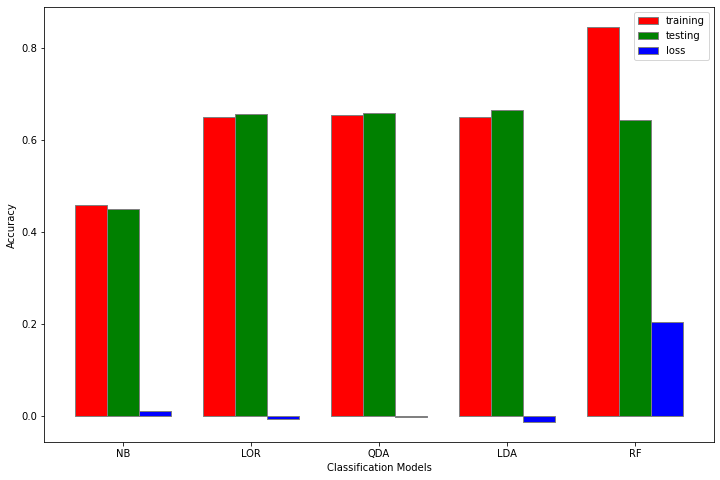

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Classification Models', ylabel='Accuracy'>)

In [ ]:
# function to produce a barplot visualising the training, testing and generalisation loss to aid our decision making
def barplot(training, testing, diff,classes):
    #width of bar
    barwidth =  0.25
    fig = plt.subplots(figsize = (12,8))

    # position of bar on x axis
    br1 = np.arange(len(training))
    br2 = [x + barwidth for x in br1]
    br3 = [x + barwidth for x in br2]

    # make the plot
    plt.bar(br1, training, color ='r', width = barwidth, edgecolor='grey',label='training')
    plt.bar(br2, testing, color ='g', width = barwidth, edgecolor='grey', label ='testing')
    plt.bar(br3, diff, color ='b', width = barwidth, edgecolor ='grey',label ='loss')

    # labelling
    plt.xticks([r + barwidth for r in range(len(training))],['NB','LOR','QDA','LDA','RF'])
    plt.legend()
    plt.xlabel(classes)
    plt.ylabel('Accuracy')
    plt.show()

    return fig

# inserting all accuracy values into list to be displayed on barplot
training_eva = [acc_nb_train, acc_lor_train, acc_qda_train,acc_lda_train,acc_rfc_train]
testing_eva = [acc_nb_test, acc_lor_test, acc_qda_test,acc_lda_test,acc_rfc_test]
diff_eva = [acc_nb_diff, acc_lor_diff, acc_qda_diff,acc_lda_diff,acc_rfc_diff]

# plotting
plot = barplot(training_eva,testing_eva,diff_eva, 'Classification Models')
plot


RF is eliminated due to its high generalisation loss. Among the others, LDA has the best accuracies. Hence, it is chosen.

In [ ]:
# double checking the accuracy values
print(training_eva)
print(testing_eva)

[0.45897300158814186, 0.6498147167813658, 0.6543144520910534, 0.6503440974060349, 0.8464796188459502]
[0.4486772486772487, 0.6571428571428571, 0.6582010582010582, 0.6645502645502646, 0.6433862433862434]


# Final Prediction
Finally, we have chosen our best performing classification model and we can now use it to make predictions for our final test set.

In [ ]:
# prepare dataset by inserting columns for features
df_predict = pd.read_csv('epl-test.csv')
df_teamnames = df_predict.copy()
df_teamnames = conv_clubname_to_int(df_teamnames,clubnames)
df_predict['EloDiff'] = ""
df_predict['LastNPoints'] = ""
df_predict['Ex'] = ""
df_predict['NetSpend'] = ""
df_predict['Distance Travelled by Away Team'] = ""

# inserting all features into their respective columns
for n in range(len(df_predict)):
    w6 = 0.8 # weightage for home/away elo
    w7 = 1-w6 # weightage for avg elo
    initial_elohome = (w6 * EloHome_list[df_teamnames.iloc[n,1]]) + (w7 * EloAvg_list[df_teamnames.iloc[n,1]])
    initial_eloaway = (w6 * EloAway_list[df_teamnames.iloc[n,2]]) + (w7 * EloAvg_list[df_teamnames.iloc[n,2]])
    elodiff = initial_elohome - initial_eloaway
    df_predict.iloc[n,3] = elodiff
    lastNPoints = lastNPoints_df_test.iloc[n,0] - lastNPoints_df_test.iloc[n,1]
    Ex = spending_df_test.iloc[n,0]-spending_df_test.iloc[n,2]
    Spending = spending_df_test.iloc[n,1]-spending_df_test.iloc[n,3]
    Dist = dist_df_test.iloc[n,0]
    df_predict.iloc[n,4] = lastNPoints
    df_predict.iloc[n,5] = Ex
    df_predict.iloc[n,6] = Spending
    df_predict.iloc[n,7] = Dist

df_predict

# drop date, home and away teams from our feature dataset as they should not affect the output
x_predict = df_predict.drop(['Date','HomeTeam','AwayTeam'],axis = 1)

# standardise
x_predict_scale = scaler.fit_transform(x_predict)

In [ ]:
# perform final prediction with the chosen LDA model
y_predict = lda_fit.predict(x_predict_scale)
y_prob = lda_fit.predict_proba(x_predict_scale)
print('predicted outcomes: ',y_predict)
print('confidence level of predicted outcomes: ',y_prob)

predicted outcomes:  ['A' 'H' 'H' 'A' 'H' 'H' 'A' 'H' 'H' 'A']
confidence level of predicted outcomes:  [[0.726 0.18  0.095]
 [0.002 0.194 0.803]
 [0.003 0.191 0.806]
 [0.449 0.336 0.216]
 [0.291 0.35  0.359]
 [0.005 0.194 0.801]
 [0.986 0.012 0.002]
 [0.033 0.286 0.681]
 [0.052 0.278 0.67 ]
 [0.601 0.236 0.162]]


In [ ]:
# present predictions in a table with date, home and away teams
Submission_results=pd.read_csv('epl-test.csv',index_col=0, encoding='ISO-8859-1')
Submission_results['FTR'] = y_predict
Submission_results['Probability of H'] = y_prob[:,2]
Submission_results['Probability of D'] = y_prob[:,1]
Submission_results['Probability of A'] = y_prob[:,0]
Submission_results

,HomeTeam,AwayTeam,FTR,Probability of H,Probability of D,Probability of A
Date,,,,,,
15-01-22,Aston Villa,Man United,A,0.094587,0.179893,0.725520
15-01-22,West Ham,Leeds,H,0.803488,0.194201,0.002312
15-01-22,Norwich,Everton,H,0.805931,0.190682,0.003387
15-01-22,Brighton,Crystal Palace,A,0.215703,0.335643,0.448654
15-01-22,Wolves,Southampton,H,0.358869,0.350272,0.290859
15-01-22,Liverpool,Brentford,H,0.800754,0.193959,0.005287
15-01-22,Tottenham,Arsenal,A,0.001936,0.012074,0.985990
15-01-22,Man City,Chelsea,H,0.681126,0.286167,0.032706
15-01-22,Newcastle,Watford,H,0.670242,0.278092,0.051666


In [ ]:
# export results to csv file
Submission_results.to_csv (r'Submission_results.csv', index = True, header=True)